In [60]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import scikit_posthocs as sp
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict
from os import listdir

In [61]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

### Import list of all experiments

In [62]:
path='../../NGS/20230420_TnpB_CasMini_CjPAM_Libraries/CjCas9-PAM/Output/Analysis/'
def list_files1(directory):
    return [f for f in listdir(directory) if 'LS' in f]

sampledf = pd.DataFrame(columns=['filename','Cell_line','Editor','Replicate'])
filelist = list_files1(path)
sampledf['filename'] = filelist
sampledf['Library'] = 'CjCas9-PAM-Lib'
sampledf['Editor'] = sampledf['filename'].apply(lambda x: x.split('-')[1])
sampledf['Day'] = sampledf['filename'].apply(lambda x: x.split('_')[1].split('-')[-2][1:])
sampledf['Control'] = sampledf['filename'].apply(lambda x: True if 'ctrl' in x else False)
sampledf.loc[sampledf['Control'] == True, 'Editor'] = 'ctrl'

sampledf['Editor_Day'] = sampledf.apply(lambda x: x.Editor+'_'+x.Day ,axis=1)
sampledf['Replicate'] = sampledf['filename'].apply(lambda x: x[-5:-4])
# set values in column 'Editor' to "ctrl" if 'Control' is True

sampledf['repname'] = sampledf.apply(lambda x: x.Editor+"_"+x.Day+"_"+x.Replicate,axis=1)
#sampledf['Cell_line_Editor'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor,axis=1)
#sampledf['repname'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor+"_"+x.Replicate,axis=1)

In [63]:
sampledf

,filename,Cell_line,Editor,Replicate,Library,Day,Control,Editor_Day,repname
0,20230423_LS-p551-ctrl-D10-R1.csv,NaN,ctrl,1,CjCas9-PAM-Lib,10,True,ctrl_10,ctrl_10_1
1,20230423_LS-p551-ctrl-D10-R2.csv,NaN,ctrl,2,CjCas9-PAM-Lib,10,True,ctrl_10,ctrl_10_2
2,20230423_LS-p551-ctrl-D10-R3.csv,NaN,ctrl,3,CjCas9-PAM-Lib,10,True,ctrl_10,ctrl_10_3
3,20230423_LS-p551evo-D10-R1.csv,NaN,p551evo,1,CjCas9-PAM-Lib,10,False,p551evo_10,p551evo_10_1
4,20230423_LS-p551evo-D10-R2.csv,NaN,p551evo,2,CjCas9-PAM-Lib,10,False,p551evo_10,p551evo_10_2
5,20230423_LS-p551evo-D10-R3.csv,NaN,p551evo,3,CjCas9-PAM-Lib,10,False,p551evo_10,p551evo_10_3
6,20230423_LS-p551wlt-D10-R1.csv,NaN,p551wlt,1,CjCas9-PAM-Lib,10,False,p551wlt_10,p551wlt_10_1
7,20230423_LS-p551wlt-D10-R2.csv,NaN,p551wlt,2,CjCas9-PAM-Lib,10,False,p551wlt_10,p551wlt_10_2
8,20230423_LS-p551wlt-D10-R3.csv,NaN,p551wlt,3,CjCas9-PAM-Lib,10,False,p551wlt_10,p551wlt_10_3


In [64]:
templatedf = pd.read_csv('20230201_Cj_PAM_library_500.csv')

### Calculate control characteristics for each experimental setup

In [65]:
ctrllist = sampledf[sampledf['Editor'] == 'ctrl']
ctrldf = templatedf.copy()
for index, row in ctrllist.iterrows():
    controlrepdf = pd.read_csv(path+row.filename)
    ctrldf[row.repname+'_totalreads'] = controlrepdf['totalreads']
    controlrepdf['percentageindel'] = controlrepdf.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
    controlrepdf['percentageunedited'] = controlrepdf.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
    ctrldf[row.repname+'_percentageunedited'] = controlrepdf['percentageunedited']
    ctrldf[row.repname+'_percentageindel'] = controlrepdf['percentageindel']
    ctrldf[row.repname+'_uneditedcount'] = controlrepdf['uneditedcount']
    ctrldf[row.repname+'_indelcount'] = controlrepdf['indelcount']

for index, row in ctrllist.iterrows():    
    ctrldf = ctrldf[ctrldf[row.repname+'_totalreads'] > 100]
    ctrldf = ctrldf[ctrldf[row.repname+'_percentageindel'] < 30]

In [66]:
editordaylist = sampledf['Editor_Day'].unique()
editordaylist = [x for x in editordaylist if not 'ctrl' in x]
experimentdict = {}
for editor_day in editordaylist:
    experimentdf = templatedf.copy()
    for index, row in sampledf[sampledf['Editor_Day'] == editor_day].iterrows():
        dataframe = pd.read_csv(path+row.filename)
        dataframename = row.Editor+"_"+row.Day+"_"+row.Replicate
        day = row.Day
        experimentdf[dataframename+'_totalreads'] = dataframe['totalreads']
        dataframe['percentageindel'] = dataframe.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
        dataframe['percentageunedited'] = dataframe.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
        experimentdf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
        experimentdf[dataframename+'_percentageindel'] = dataframe['percentageindel']
        experimentdf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
        experimentdf[dataframename+'_indelcount'] = dataframe['indelcount']
        
    replicates = list(sampledf[sampledf['Editor_Day'] == editor_day].repname)
    controldf = sampledf[(sampledf['Editor'] == 'ctrl') & (sampledf['Day'] == day)]    
    #controlname = controldf['Cell_line_Editor'] + '_' + controldf['Replicate']
    
    ctrluneditedlist = []
    ctrlindellist = []
    lib = "Nme"
    for index, row in controldf.iterrows():
        ctrluneditedlist.append(row.repname+'_percentageunedited')
        ctrlindellist.append(row.repname+'_percentageindel')
        
    experimentdf['ctr'+'_'+day+'_percentageunedited'] = ctrldf[ctrluneditedlist].mean(axis=1)
    experimentdf['ctr'+'_'+day+'_percentageindel'] = ctrldf[ctrlindellist].mean(axis=1)

    cutoff = 100
    initialtemplen = len(experimentdf)

    for replicate in replicates:
        experimentdf = experimentdf[experimentdf[replicate+'_totalreads']>cutoff]
    print(editor_day)
    print(len(experimentdf))
    print()
    experimentdict[editor_day] = experimentdf

p551evo_10
489

p551wlt_10
454



### Calculate editing characteristics for all experimental setups
Also clip editing levels to be between 0-100.

In [67]:
sampledf_woctr = sampledf[sampledf['Editor'] != 'ctrl']

In [68]:
editordaydf = sampledf_woctr.copy()
editordaydf = editordaydf[editordaydf['Replicate'] == "1"]
editordaydf = editordaydf.set_index('Editor_Day')

cols = ['Editor', 'Library', 'Day']
editordaydf = editordaydf[cols]
editordaydf

,Editor,Library,Day
Editor_Day,,,
p551evo_10,p551evo,CjCas9-PAM-Lib,10
p551wlt_10,p551wlt,CjCas9-PAM-Lib,10


In [69]:
experimentdict

{'p551evo_10':                   Identifier      Name          Number            5'Overhang  \
 0                     Cj_001        Cj               1  GTGGAAAGGACGAAACACCG   
 1                     Cj_002        Cj               2  GTGGAAAGGACGAAACACCG   
 2                     Cj_003        Cj               3  GTGGAAAGGACGAAACACCG   
 3                     Cj_004        Cj               4  GTGGAAAGGACGAAACACCG   
 5                     Cj_006        Cj               6  GTGGAAAGGACGAAACACCG   
 ..                       ...       ...             ...                   ...   
 531     Cj_end32_ZNF212 no 1  Cj_end32     ZNF212 no 1  GTGGAAAGGACGAAACACCG   
 532     Cj_end33_TARDBP no 1  Cj_end33     TARDBP no 1  GTGGAAAGGACGAAACACCG   
 533         Cj_end34_NECTIN2  Cj_end34         NECTIN2  GTGGAAAGGACGAAACACCG   
 534      Cj_end35_FANCF no 1  Cj_end35      FANCF no 1  GTGGAAAGGACGAAACACCG   
 535  Cj_end36_HEK site no 18  Cj_end36  HEK site no 18  GTGGAAAGGACGAAACACCG   
 
            

In [70]:
for editor_day in experimentdict:
    print(editor_day)
    replicatelist = list(sampledf_woctr[sampledf_woctr['Editor_Day'] == editor_day]['repname'])
    day = editor_day.split('_')[1]
    ctrname = 'ctr'+'_'+day
    
    for replicate in replicatelist:
        print(replicate)
        repnr = replicate.split('_')[-1]
        experimentdict[editor_day][replicate+'_percentageindel_corrected_individual'] = experimentdict[editor_day].apply(lambda x: ((x[replicate+'_percentageindel']-x[ctrname+'_percentageindel'])/((100-x[ctrname+'_percentageindel'])/100)),axis=1)
        editordaydf.at[editor_day,repnr +'_meanindel'] = None
        editordaydf.at[editor_day,repnr +'_meanindel'] = experimentdict[editor_day][[replicate +'_percentageindel_corrected_individual']].mean()
        
    allreps = []
    for index,row in sampledf_woctr[sampledf_woctr['Editor_Day'] == editor_day].iterrows():
        rep = row.Editor_Day+'_'+row.Replicate
        allreps.append(rep)
        
    print(allreps)    
    experimentdict[editor_day][editor_day+'_averageindel'] = experimentdict[editor_day][[x +'_percentageindel_corrected_individual' for x in allreps]].mean(axis=1)
    
       
    # Clip editing rates to be between 0 and 100
    experimentdict[editor_day][editor_day+'_averageindel'] = experimentdict[editor_day][editor_day+'_averageindel'].clip(0,100)
    
    experimentdict[editor_day] = experimentdict[editor_day].dropna(subset=[editor_day+'_averageindel'])
    
    
    
    
    
    editordaydf.at[editor_day,'numberofvariants'] = len(experimentdict[editor_day])
    editordaydf.at[editor_day,'meanindel'] = experimentdict[editor_day][editor_day+'_averageindel'].mean()
    editordaydf.at[editor_day,'standarddeviation'] = experimentdict[editor_day][editor_day+'_averageindel'].std()
    # experimentdict[editor_day].to_csv('./AnalysisFiles/summary/20230319_'+editor_day+'_analysis_dataframe.csv')
    path='../../NGS/20230420_TnpB_CasMini_CjPAM_Libraries/CjCas9-PAM/Output/Analysis/summary/'
    experimentdict[editor_day].to_csv(path+'20230424_'+editor_day+'_analysis_dataframe.csv')

p551evo_10
p551evo_10_1
p551evo_10_2
p551evo_10_3
['p551evo_10_1', 'p551evo_10_2', 'p551evo_10_3']
p551wlt_10
p551wlt_10_1
p551wlt_10_2
p551wlt_10_3
['p551wlt_10_1', 'p551wlt_10_2', 'p551wlt_10_3']


In [71]:
for index, row in editordaydf.iterrows():
    editordaydf.at[index,'replicate_meanindel'] = (row['1_meanindel'] + row['2_meanindel'] + row['3_meanindel']) / 3
    editordaydf.at[index,'replicate_std'] = np.std([row['1_meanindel'],row['2_meanindel'],row['3_meanindel']])

In [72]:
editordaydf['Day'] = editordaydf['Day'].apply(lambda x: int(x))
editordaydf = editordaydf.sort_values('Day')
editordaydf = editordaydf.sort_values('Editor')
editordaydf['filename'] = editordaydf.apply(lambda x: '20230424_'+x.Editor+'_'+str(x.Day)+'_analysis_dataframe.csv',axis=1)
path='../../NGS/20230420_TnpB_CasMini_CjPAM_Libraries/CjCas9-PAM/Output/Analysis/summary/'

editordaydf.to_csv(path+'20230424_CjCas9-PAM_LS_summary_mean_std.csv')
editordaydf

,Editor,Library,Day,1_meanindel,2_meanindel,3_meanindel,numberofvariants,meanindel,standarddeviation,replicate_meanindel,replicate_std,filename
Editor_Day,,,,,,,,,,,,
p551evo_10,p551evo,CjCas9-PAM-Lib,10,55.997114,49.187323,43.873719,401.0,49.690874,27.837902,49.686052,4.961903,20230424_p551evo_10_analysis_dataframe.csv
p551wlt_10,p551wlt,CjCas9-PAM-Lib,10,20.195951,16.485388,20.103420,399.0,19.406677,27.713589,18.928253,1.727779,20230424_p551wlt_10_analysis_dataframe.csv


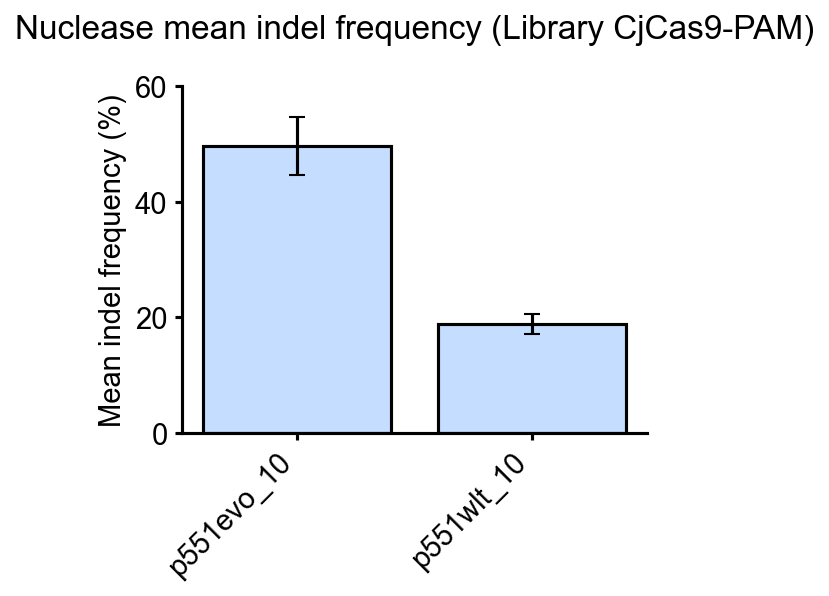

In [73]:
conditionlist = list(editordaydf.index)
meanlist = list(editordaydf.replicate_meanindel)
stdlist = list(editordaydf.replicate_std)

fig1, ax1 = plt.subplots(figsize = (4,3),dpi=150,sharex=True)
ax1.set_title('Nuclease mean indel frequency (Library CjCas9-PAM)\n', fontsize=titlesize)
ax1.bar(conditionlist,meanlist,yerr=stdlist, **bar_kwargs)
ax1.set_xticks(range(len(conditionlist)))
ax1.set_xticklabels(conditionlist, ha="right")
#ax1.set_yticks(np.linspace(0,1,11))
ax1.set_ylabel('Mean indel frequency (%)', fontsize=lsize)
ax1.tick_params(axis='x', labelsize= lsize, width=1.5, rotation=45)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
ax1.set_ylim(0,60)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#figurepath = 'C:\\Users\\nicol\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\'
#plt.savefig(figurepath+'Nuclease_1421_meanefficiency.pdf', format='pdf',
#        transparent=True,bbox_inches='tight')